In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

import rasterio
import geopandas as gpd

import iceplant_detection_functions as ipf
import model_prep_and_evals as mpe

import warnings

import planetary_computer as pc
import rioxarray as rioxr

import gc # garbage collector

import dask
import dask_gateway
import dask.array as da
from dask_ml.wrappers import ParallelPostFit

from shapely.geometry import Polygon

# Import train set

In [2]:
X_train = pd.read_csv(os.path.join(os.getcwd(),'data_sampling_workflow','train_set.csv')).loc[:,'r':'avg_lidar']
y_train = pd.read_csv(os.path.join(os.getcwd(),'data_sampling_workflow','train_set.csv')).loc[:,'iceplant'] 

In [3]:
X_train = X_train.drop(['lidar','max_lidar','min_lidar','min_max_diff','avg_lidar'],axis=1)
X_train.head(3)

,r,g,b,nir,ndvi,year,month,day_in_year
0,43,51,78,89,0.348485,2012,5,126
1,65,59,84,79,0.097222,2012,5,126
2,81,86,93,132,0.239437,2012,5,126


## Train model

In [4]:
t0 = time.time()

rfc = ParallelPostFit(RandomForestClassifier(n_estimators = 100, random_state = 42))
rfc.fit(X_train, y_train)

print('time to train: ', (time.time()-t0))

time to train:  36.61416673660278


# Probabilities over aoi

## Specify aoi

In [5]:
aois = gpd.read_file(os.path.join(os.getcwd(),'areas_of_interest','areas_of_interest.shp'))
aois

,name,region,itemid_12,itemid_14,itemid_16,itemid_18,itemid_20,geometry
0,conception point,dangermond,ca_m_3412037_nw_10_1_20120518_20120730,ca_m_3412037_nw_10_1_20140603_20141030,NA,ca_m_3412037_nw_10_060_20180913_20190208,ca_m_3412037_nw_10_060_20200607,"POLYGON ((-120.47317 34.44646, -120.47317 34.4..."
1,government point,dangermond,ca_m_3412037_nw_10_1_20120518_20120730,ca_m_3412037_nw_10_1_20140603_20141030,NA,ca_m_3412037_nw_10_060_20180913_20190208,ca_m_3412037_nw_10_060_20200607,"POLYGON ((-120.46002 34.44189, -120.46002 34.4..."
2,near dangermond test plots,dangermond,ca_m_3412037_nw_10_1_20120518_20120730,ca_m_3412037_nw_10_1_20140603_20141030,NA,ca_m_3412037_nw_10_060_20180913_20190208,ca_m_3412037_nw_10_060_20200607,"POLYGON ((-120.47391 34.45923, -120.47391 34.4..."
3,dangermond inland,dangermond,ca_m_3412037_nw_10_1_20120518_20120730,ca_m_3412037_nw_10_1_20140603_20141030,NA,ca_m_3412037_nw_10_060_20180913_20190208,ca_m_3412037_nw_10_060_20200607,"POLYGON ((-120.45624 34.45427, -120.45624 34.4..."
4,campus point,goleta,ca_m_3411934_sw_11_1_20120505_20120730,ca_m_3411934_sw_11_1_20140601_20141030,ca_m_3411934_sw_11_.6_20160713_20161004,ca_m_3411934_sw_11_060_20180722_20190209,ca_m_3411934_sw_11_060_20200521,"POLYGON ((-119.85347 34.40287, -119.85347 34.4..."
5,campus lagoon zoom,goleta,ca_m_3411934_sw_11_1_20120505_20120730,ca_m_3411934_sw_11_1_20140601_20141030,ca_m_3411934_sw_11_.6_20160713_20161004,ca_m_3411934_sw_11_060_20180722_20190209,ca_m_3411934_sw_11_060_20200521,"POLYGON ((-119.85019 34.40848, -119.85019 34.4..."
6,campus lagoon tree,goleta,ca_m_3411934_sw_11_1_20120505_20120730,ca_m_3411934_sw_11_1_20140601_20141030,ca_m_3411934_sw_11_.6_20160713_20161004,ca_m_3411934_sw_11_060_20180722_20190209,ca_m_3411934_sw_11_060_20200521,"POLYGON ((-119.84943 34.40982, -119.84943 34.4..."
7,shoreline park,santa barbara,NA,NA,NA,ca_m_3411935_sw_11_060_20180724_20190209,NA,"POLYGON ((-119.71415 34.39310, -119.71415 34.3..."


In [6]:
# Fields next to Golet Slough

reduce_box = Polygon([[-119.8284196946,34.4162731913],
                       [-119.8101541026,34.4162731913],
                       [-119.8101541026,34.4353838099],
                       [-119.8284196946,34.4353838099],
                       [-119.8284196946,34.4162731913]])

In [7]:
aoi = aois.iloc[4] # Campus Lagoon aoi
itemid = aoi.itemid_12
geometry = reduce_box
image = ipf.open_window_in_scene(itemid, geometry)

In [8]:
save_raster = True
year = 2012
aoi = 'goleta_fields'
filename = 'SPECTRAL_'+aoi+'_'+str(year)+'_probabilities.tif'

## Add features for prediction

In [9]:
veg_df = ipf.features_over_aoi(ipf.get_item_from_id(itemid), 
                           image, 
                           thresh=0.05)
veg_df.head(3)

,r,g,b,nir,ndvi,year,month,day_in_year
55,124,121,135,142,0.067669,2012,5,126
67,116,122,128,167,0.180212,2012,5,126
68,113,124,137,181,0.231293,2012,5,126


## Calculate probabilities

In [10]:
scene_probs = rfc.predict_proba(veg_df.to_numpy())
scene_probs

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.68, 0.32],
       [0.34, 0.66],
       [0.  , 1.  ],
       ...,
       [0.69, 0.31],
       [0.52, 0.48],
       [0.59, 0.41]])

## Assemble dataframe with iceplant and non-iceplant probabilities

In [11]:
ip_probs = np.reshape(scene_probs, scene_probs.shape[0]*2)[1::2] * 100
ip_probs = ip_probs.astype('int16')
#np.unique(ip_probs)

In [12]:
ip_probs

array([ 32,  66, 100, ...,  31,  48,  41], dtype=int16)

In [13]:
nonip_probs = np.reshape(scene_probs, scene_probs.shape[0]*2)[::2] * 100
nonip_probs = nonip_probs.astype('int16')
#np.unique(nonip_probs)

In [14]:
nonip_probs

array([68, 34,  0, ..., 69, 52, 59], dtype=int16)

In [15]:
d = {'ip_prob': ip_probs,
     'non_ip_prob' : nonip_probs}
probs_df = pd.DataFrame(data = d)
probs_df

,ip_prob,non_ip_prob
0,32,68
1,66,34
2,100,0
3,41,59
4,91,9
...,...,...
1194234,8,92
1194235,37,63
1194236,31,69
1194237,48,52


In [17]:
x = probs_df.ip_prob + probs_df.non_ip_prob
x.unique()

array([100,  99,  98], dtype=int16)

## Reconstruct iceplant probs into raster

In [16]:
def probs_backto_image(nrows, ncols, index, probs):
    reconstruct = np.zeros((nrows,ncols))
    m=0
    for n in index:
        if probs[m]!=0:
            i = int(n / ncols)
            j = n % ncols
            reconstruct[i][j] = probs[m]
        m = m+1
    return reconstruct

In [18]:
probs_image = probs_backto_image(image.shape[1], image.shape[2], veg_df.index, ip_probs)

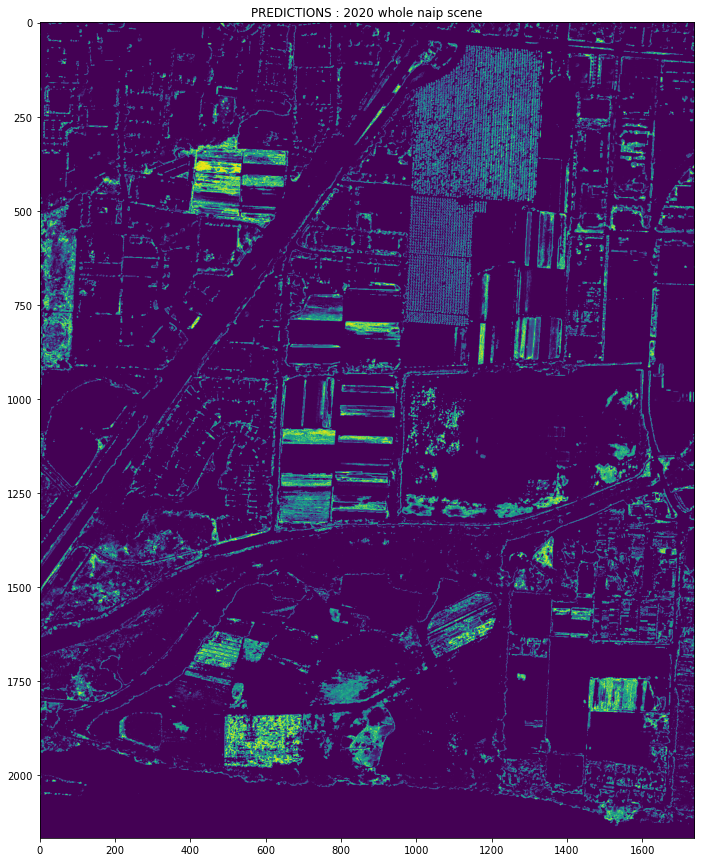

In [19]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : 2020 whole naip scene")
ax.imshow(probs_image)
plt.show()

In [20]:
def small_raster(itemid, reduce_box):
    item = ipf.get_item_from_id(itemid)
    href = pc.sign(item.assets["image"].href)
    
    rast = rioxr.open_rasterio(href)
    
    reduce = gpd.GeoDataFrame({'geometry':[reduce_box]}, crs="EPSG:4326")
    reduce = reduce.to_crs(rast.rio.crs)    
    
    rast_small = rast.rio.clip_box(*reduce.total_bounds)
    return rast_small

In [21]:
# save if necessary

if save_raster == True:
    
    small = small_raster(itemid,  geometry)
    
    with rasterio.open(
        os.path.join(os.getcwd(),'temp',filename),  # file path
        'w',           # w = write
        driver='GTiff', # format
        height = probs_image.shape[0], 
        width = probs_image.shape[1],
        count = 1,  # number of raster bands in the dataset
        dtype = rasterio.uint8,
        crs = small.rio.crs,
        transform = small.rio.transform(),
    ) as dst:
        dst.write(probs_image.astype(rasterio.uint8), 1)